In [1]:
from pyts.image import GramianAngularField, MarkovTransitionField, RecurrencePlot
import matplotlib.pyplot as plt

import sys
sys.path.insert(0, '../../src/utils')
import aes
import constants

In [2]:
# Basics
import trsfile
import numpy as np
from tensorflow.keras.utils import to_categorical
from sklearn.preprocessing import StandardScaler
import random



class DataLoader():


    def __init__(self, configs, n_tot_traces, target, byte_idx=None):
        
        self.trace_files = [f'{constants.CURR_TRACES_PATH}/{c}_500MHz + Resampled.trs' 
                            for c in configs]
                            
        self.n_tr_per_config = int(n_tot_traces / len(configs))
        
        self.byte_idx = byte_idx
        
        self.target = target
        self.n_classes = constants.N_CLASSES[target]
        
        # self.scaler = StandardScaler()
        
    
    def _retrieve_metadata(self, tr):

        p = np.array(tr.get_input()) # int list
        k = np.array(tr.get_key()) # int list
        l = aes.labels_from_key(p, k, self.target) # Compute the set of 16 labels

        if self.byte_idx is not None:
            l = l[self.byte_idx]
            p = p[self.byte_idx]
            k = k[self.byte_idx]

        l = to_categorical(l, self.n_classes)
        
        return l, p, k
        
        
    @staticmethod
    def _shuffle(x, y, pbs, tkbs):
        
        to_shuffle = list(zip(x, y, pbs, tkbs))
        random.shuffle(to_shuffle)
        x, y, pbs, tkbs = zip(*to_shuffle)
        
        x = np.array(x)
        y = np.array(y)
        pbs = np.array(pbs)
        tkbs = np.array(tkbs)
        
        return x, y, pbs, tkbs
        
        
    def load(self):
    
        samples = []
        labels = []
        pltxt_bytes = []
        true_key_bytes = []
        
        for tfile in self.trace_files:
            with trsfile.open(tfile, 'r') as traces:
                for tr in traces[:self.n_tr_per_config]:
                    s = tr.samples
                    l, p, k = self._retrieve_metadata(tr)
                    samples.append(s)
                    labels.append(l)
                    pltxt_bytes.append(p)
                    true_key_bytes.append(k)
                    
        x = np.array(samples) # (n_tot_traces x trace_len)
        # x = self.scaler.fit_transform(x)
        y = np.array(labels) # (n_tot_traces x n_classes)
        pbs = np.array(pltxt_bytes) # (n_tot_traces x 1)
        tkbs = np.array(true_key_bytes) # (n_tot_traces x 1)
        
        x, y, pbs, tkbs = self._shuffle(x, y, pbs, tkbs)
        
        if len(self.trace_files) == 1:
            tkbs = tkbs[0] # All true_key_bytes are equal because the config is unique 
            
        return x, y, pbs, tkbs
        
        
class SplitDataLoader(DataLoader):
   
    def __init__(self, configs, n_tot_traces, train_size, target, byte_idx=None):
        
        super().__init__(configs, n_tot_traces, target, byte_idx)
        
        self.n_train_tr_per_config = int(train_size * self.n_tr_per_config)
        
        
    def load(self):
    
        x_train = []
        y_train = []
        pbs_train = []
        tkbs_train = []
        
        x_val = []
        y_val = []
        pbs_val = []
        tkbs_val = []
        
        for tfile in self.trace_files:
            
            config_s = []
            config_l = []
            config_p = []
            config_k = []
            
            with trsfile.open(tfile, 'r') as traces:
                for tr in traces[:self.n_tr_per_config]:
                    s = tr.samples
                    l, p, k = self._retrieve_metadata(tr)
                    
                    config_s.append(s)
                    config_l.append(l)
                    config_p.append(p)
                    config_k.append(k)
            
            x_train.append(config_s[:self.n_train_tr_per_config])
            x_val.append(config_s[self.n_train_tr_per_config:])
            
            y_train.append(config_l[:self.n_train_tr_per_config])
            y_val.append(config_l[self.n_train_tr_per_config:])
            
            pbs_train.append(config_p[:self.n_train_tr_per_config])
            pbs_val.append(config_p[self.n_train_tr_per_config:])
            
            tkbs_train.append(config_k[:self.n_train_tr_per_config])
            tkbs_val.append(config_k[self.n_train_tr_per_config:])
        
        # Reduce the lists of arrays to a single np.ndarray
        x_train = np.concatenate(x_train)
        y_train = np.concatenate(y_train)
        pbs_train = np.concatenate(pbs_train)
        tkbs_train = np.concatenate(tkbs_train)
        
        x_val = np.concatenate(x_val)
        y_val = np.concatenate(y_val)
        pbs_val = np.concatenate(pbs_val)
        tkbs_val = np.concatenate(tkbs_val)
        
        # Scale the whole train-set (train + val) with the same scaler
        n_tot_train = x_train.shape[0] # train_size * n_tot_traces
        x_tot = np.concatenate([x_train, x_val])
        # x_tot = self.scaler.fit_transform(x_tot)
        x_train = x_tot[:n_tot_train]
        x_val = x_tot[n_tot_train:]
        
        # Shuffle the sets
        x_train, y_train, pbs_train, tkbs_train = self._shuffle(x_train, y_train, pbs_train, tkbs_train)
        x_val, y_val, pbs_val, tkbs_val = self._shuffle(x_val, y_val, pbs_val, tkbs_val) 
            
        # Create train and test packages
        train_data = (x_train, y_train, pbs_train, tkbs_train)
        val_data = (x_val, y_val, pbs_val, tkbs_val)
            
        return train_data, val_data

In [3]:
d1k0_dl = DataLoader(
    ['D1-K0'], 
    50000,
    byte_idx=0, 
    target='SBOX_OUT'
)

d1k0, _, _, _ = d1k0_dl.load()


d1k3_dl = DataLoader(
    ['D1-K3'], 
    50000,
    byte_idx=0, 
    target='SBOX_OUT'
)

d1k3, _, _, _ = d1k3_dl.load()


d1k8_dl = DataLoader(
    ['D1-K8'], 
    50000,
    byte_idx=0, 
    target='SBOX_OUT'
)

d1k8, _, _, _ = d1k8_dl.load()

In [ ]:
gaf = GramianAngularField()

im10 = gaf.fit_transform(d1k0[:5])
im13 = gaf.fit_transform(d1k3[:5])
im18 = gaf.fit_transform(d1k8[:5])

images = [im10, im13, im18]

f, ax = plt.subplots(3, 5, figsize=(20,12))
for i in range(3):
    for j in range(5):
        ax[i][j].imshow(images[i][j])
# plt.imshow(im10[1])
# plt.show()
# plt.imshow(im13[1])
# plt.show()
# plt.imshow(im18[1])
# plt.show()

In [ ]:
mtf = MarkovTransitionField()

im10 = mtf.fit_transform(d1k0[:5])
im13 = mtf.fit_transform(d1k3[:5])
im18 = mtf.fit_transform(d1k8[:5])

images = [im10, im13, im18]

f, ax = plt.subplots(3, 5, figsize=(20,12))
for i in range(3):
    for j in range(5):
        ax[i][j].imshow(images[i][j])

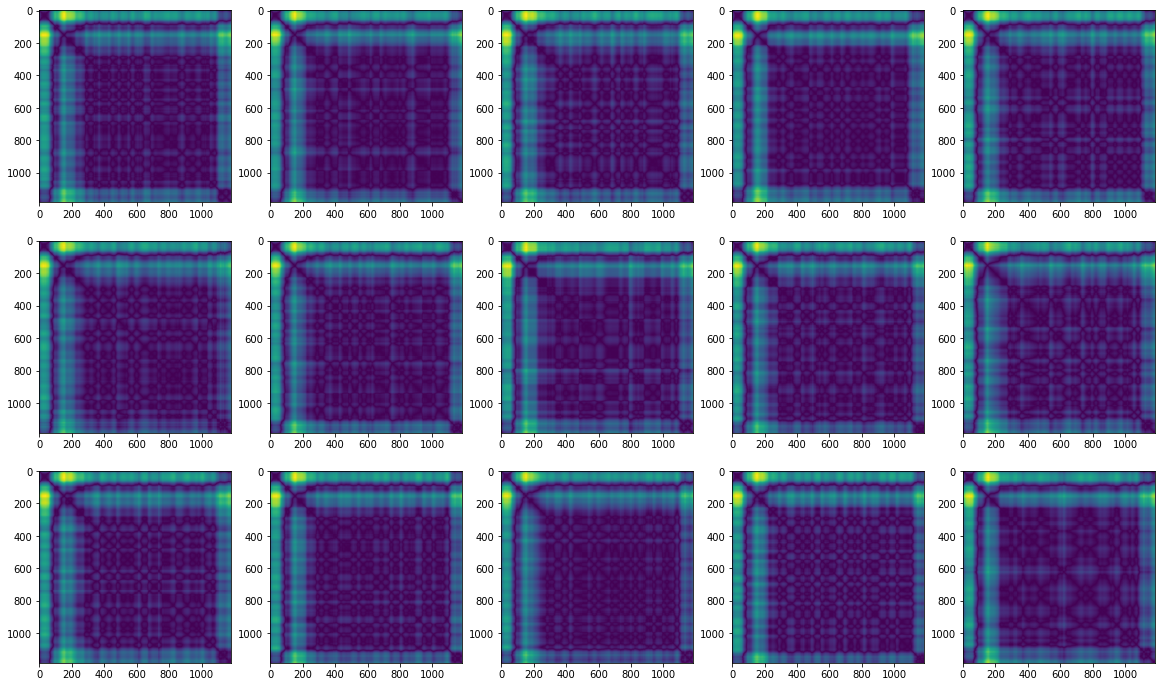

In [23]:
rp = RecurrencePlot()

im10 = rp.fit_transform(d1k0[:5])
im13 = rp.fit_transform(d1k3[:5])
im18 = rp.fit_transform(d1k8[:5])

images = [im10, im13, im18]

f, ax = plt.subplots(3, 5, figsize=(20,12))
for i in range(3):
    for j in range(5):
        ax[i][j].imshow(images[i][j])

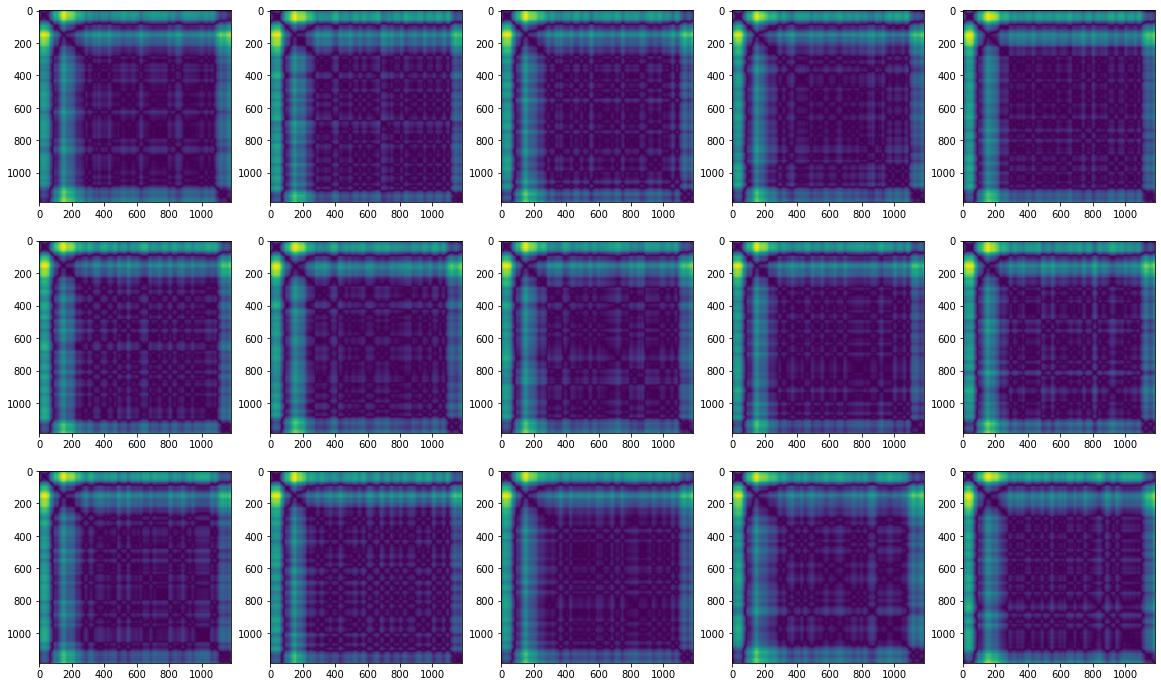

In [8]:
rp = RecurrencePlot(
#    time_delay=2, 
#    threshold='point', 
    percentage=30
)

im10 = rp.fit_transform(d1k0[:5])
im13 = rp.fit_transform(d1k3[:5])
im18 = rp.fit_transform(d1k8[:5])

images = [im10, im13, im18]

f, ax = plt.subplots(3, 5, figsize=(20,12))
for i in range(3):
    for j in range(5):
        ax[i][j].imshow(images[i][j])

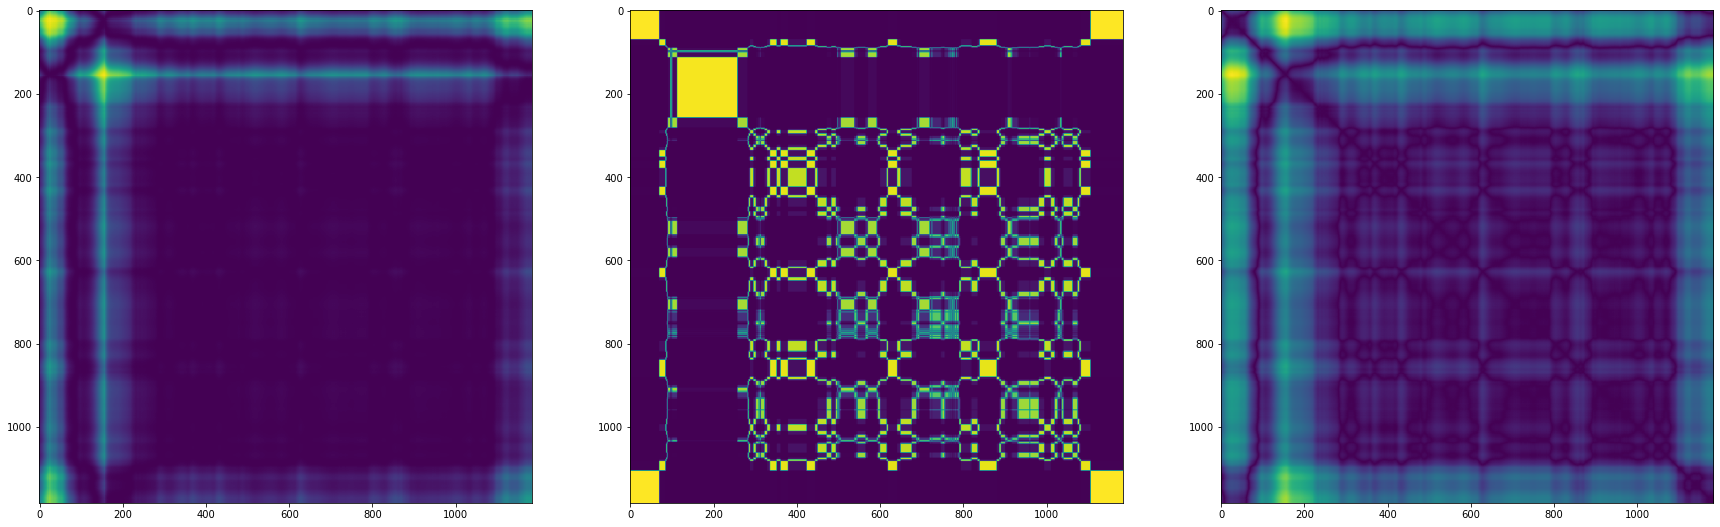

In [18]:
f, ax = plt.subplots(1, 3, figsize=(30,10))

gaf = GramianAngularField()
gaf10 = gaf.fit_transform(d1k0[:5])
ax[0].imshow(gaf10[0])

mtf = MarkovTransitionField()
mtf10 = mtf.fit_transform(d1k0[:5])
ax[1].imshow(mtf10[0])

rp = RecurrencePlot()
rp10 = rp.fit_transform(d1k0[:5])
ax[2].imshow(rp10[0])